## Table of Contents

*__(Notebook: 1_Data_Gathering)__*
- 1.0 Executive Summary

- 2.0 Imports Data and Libraries
    - 2.1 Scrapping Data: PushShift Reddit API
    - 2.2 Export Raw Data

*__(Notebook: 2_Data_Wrangling_EDA)__*

- 3.0 Data Cleaning
    - 3.1 Missing Values
    - 3.2 Duplicates
    - 3.3 Clean Irrelevant Rows
    - 3.4 Clean Newline and Emoji
    - 3.5 Clean HTML Encoded Characters
    - 3.6 Clean URL Links
    
- 4.0 Data Preprocessing
    - 4.1 Word Tokenizing Lemmatizing and Stemming
    - 4.2 Word Count and Post Length
    - 4.3 Data Dictionary

- 5.0 Exploratory Data Analysis
    - 5.1 Target Response: Subreddits
    - 5.2 Number of Comments
    - 5.3 Score
    - 5.4 Upvote Ratio
    - 5.5 Title Length and Word Count
    - 5.6 Selftext Length and Word Count
    - 5.7 Top Words Analysis
    - 5.8 Combine and Export Cleaned Data
    - 5.9 Additional: Sentiment Analysis

*__(Notebook: 3_Modeling_Evaluation_Insights)__*

- [6.0 Model Preparation](#6.0-Model-Preparation)
    - [6.1 Baseline Model](#6.1-Baseline-Model)
    - [6.2 Train Test Split](#6.2-Train-Test-Split)
    
- [7.0 Modeling and Evaluation](#7.0-Modeling-and-Evaluation)
    - [7.1 Modeling Approach](#7.1-Modeling-Approach)
    - [7.2 Evaluation Approach](#7.2-Evaluation-Approach)
    - [7.3 Logistic Regression](#7.3-Logistic-Regression)
    - [7.4 Multinomial Naive Bayes](#7.4-Multinomial-Naive-Bayes)
    - [7.5 Random Forest Classifier](#7.5-Random-Forest-Classifier)
    - [7.6 Final Model](#7.6-Final-Model)
    - [7.7 Model Insights](#7.7-Model-Insights)

- [8.0 Conclusions and Recommendations](#8.0-Conclusions-and-Recommendations)
    - [8.1 Findings](#8.1-Findings)
    - [8.2 Recommendations](#8.2-Recommendations)
    - [8.3 Future Enhancements](#8.3-Future-Enhancements)
    - [8.4 Citations](#8.4-Citations)

## Imports Libraries

In [1]:
# for data manipulation
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from matplotlib_venn import venn2

# for text preprocessing
from nltk.corpus import stopwords as sw

# for feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# for data evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, \
                            recall_score, f1_score, plot_roc_curve, roc_auc_score


### Create Functions

In [2]:
# create a function to run the metrics and store it in dataframe
evaluation_list = []

def run_score(fit_model, vec, model):
    
    summary_dict = {}
    
    y_pred = fit_model.predict(X_test)
    train = fit_model.score(X_train, y_train)
    test = fit_model.score(X_test, y_test)
    cv_score = fit_model.best_score_
    roc_auc = roc_auc_score(y_test, fit_model.predict_proba(X_test)[:,1])

    # store the results in summary dictionary
    summary_dict['model'] = model
    summary_dict['vectorizer'] = vec
    summary_dict['cross_val_score'] = cv_score
    summary_dict['train accuracy'] = train
    summary_dict['test accuracy'] = test
    summary_dict['precision'] = precision_score(y_test, y_pred)
    summary_dict['recall'] = recall_score(y_test, y_pred)
    summary_dict['f1_score'] = f1_score(y_test, y_pred)
    summary_dict['roc_auc'] = roc_auc
    
    evaluation_list.append(summary_dict)
    
    # print summarize results
    print(f"====== {model}'s Metrics ======")
    print(f"Train Score: {train}")
    print(f"Test Score: {test}")    
    print(f"Precision Score: {precision_score(y_test, y_pred)}")
    print(f"Recall Score: {recall_score(y_test, y_pred)}")
    print(f"f1-Score: {f1_score(y_test, y_pred)}")
    print(f"roc_auc Score: {roc_auc}")
    
    print()
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    print('== confusion matrix ==')
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")

In [3]:
# create function to subplot top words with highest probabilities
def subplot_top_proba(df1, df2, n=20, title=None):

    df_1 = df1.sort_values('prob', ascending=False).head(n)
    df_2 = df2.sort_values('prob', ascending=False).head(n)

    plt.figure(figsize=(18,10))
    sns.set(font_scale = 1.5)

    palette1 = sns.color_palette("flare",n_colors=n)
    palette1.reverse()
    palette2 = sns.color_palette("Blues_d",n_colors=n)
    palette2.reverse()

    ax1 = plt.subplot(1,2,1)
    ax1 = sns.barplot(y='index',x='prob', data=df_1, palette=palette1)
    ax1 = plt.xlabel('Probabilities',fontsize = 20)
    ax1 = plt.title("r/yoga", fontsize = 20)

    ax2 = plt.subplot(1,2,2)
    ax2 = sns.barplot(y='index',x='prob', data=df_2, palette=palette2)
    ax2 = plt.xlabel("Probabilities", fontsize = 20)
    ax2 = plt.title("r/Meditation", fontsize = 20)
    
    plt.suptitle(title, fontsize=25)
    plt.subplots_adjust(wspace=0.4)
    plt.savefig('../images/top_predictors.png',bbox_inches='tight');    

---

### Load Cleaned and Combined Data

In [4]:
# load the cleaned and combined datasets
yoga_medit = pd.read_csv('../datasets/yoga_medit.csv')

In [5]:
print(yoga_medit.shape)
yoga_medit.head(3)

(1679, 22)


,is_yoga,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,author,permalink,...,clean_title,clean_selftext,combine_text,lem_title,lem_selftext,lem_combine_text,title_length,title_wcount,selftext_length,selftext_wcount
0,1,Extremely sore after my first hot vinyasa class,I am super out of shape so I am 90% sure that ...,True,0,1640903618,2021-12-31 06:33:38,NaN,meggriffinsglasses,/r/yoga/comments/rse7eh/extremely_sore_after_m...,...,extremely sore after my first hot vinyasa class,i am super out of shape so i am 90 sure that i...,extremely sore after my first hot vinyasa clas...,extremely sore hot vinyasa class,super shape 90 sure issue wanted know normal p...,extremely sore hot vinyasa class super shape 9...,47,8,1041,222
1,1,Online new year's offerings?,"Hello yogis,\n\nAnybody aware of interesting y...",True,0,1640897639,2021-12-31 04:53:59,NaN,Friendly_Popo,/r/yoga/comments/rsbwvy/online_new_years_offer...,...,online new years offerings,hello yogis anybody aware of interesting yoga ...,online new years offerings hello yogis anybody...,online new year offering,hello yogi anybody aware interesting offering ...,online new year offering hello yogi anybody aw...,26,4,464,76
2,1,Yoga with COVID,Hi all. \n\nI was diagnosed with COVID last we...,True,0,1640895222,2021-12-31 04:13:42,NaN,dreamingofcupcakes,/r/yoga/comments/rsazdv/yoga_with_covid/,...,yoga with covid,hi all i was diagnosed with covid last week an...,yoga with covid hi all i was diagnosed with co...,covid,hi diagnosed covid week really giving real bad...,covid hi diagnosed covid week really giving re...,15,3,526,92


## 6.0 Model Preparation

In [6]:
# check for imbalance classes
yoga_medit['is_yoga'].value_counts(normalize=True)

0    0.586063
1    0.413937
Name: is_yoga, dtype: float64

The final dataset shows that the data is imbalance classes, which `is_yoga` consists of 1 = 41.4% and 0 = 58.6%, hence we need to stratify the data during our train-test-split later.

In [7]:
# split data into X and y
X = yoga_medit['lem_combine_text']
y = yoga_medit['is_yoga']

### 6.1 Baseline Model

We need to calculate baseline accuracy in order to tell if our model is better than null model (blindly predicting everything as the majority class).

In [8]:
# Baseline Accuracy
baseline_model = yoga_medit['is_yoga'].value_counts(normalize=True)
baseline_model

0    0.586063
1    0.413937
Name: is_yoga, dtype: float64

In this case, base on above *value_counts()* our baseline accuracy is 58.6% and we can simply predict everything as the majority class and it will give us 58.6% accuracy! So we most likely want to use precision, recall or specificity metrics instead.

### 6.2 Train Test Split

In [9]:
# split the datasets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=42,
                                                    stratify=y)

In [10]:
# check shape of the train and test sets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1175,)
X_test shape: (504,)
y_train shape: (1175,)
y_test shape: (504,)


## 7.0 Modeling and Evaluation

### 7.1 Modeling Approach

For our modeling approach, we used `Pipeline` from sklearn to apply a list of transforms and a final estimator for each `gridsearchcv` hyperparameters tuning. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps.

Transformers that we used to fit and transform our textual data are `CountVectorizer` and `TfidfVectorizer`.

`CountVectorizer` is the easiest way for us to convert text data into a structured, numeric `X` dataframe is to use `CountVectorizer`. As the name suggest, it count up the numbers of token obsered in the corpus and create a column also known as vector that stored these tokens. These tokens are now stored as __bag-of-words__. __bag-of-words__ representations discard grammar, order, and structure in the text but track occurences. 

This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix. A sparse matrix is a matrix is comprised of mostly zero values. By only storing the non-zero elements in our computer's memory, we can save a lot of space.

`TfidfVectorizer` is an abbreviation for Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer. It is a score that tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power. Variations of the TD-IDF score are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.


While the estimator or models that we used are `Logistic Regression`, `Multinomial Naive Bayes` and `Random Forest Classifier`.


### 7.2 Evaluation Approach

As our stakeholders required to spent the marketing resouces on the __right target segment (Yoga Enthusiasts)__. Our classification model have to correctly predict the yoga enthusiasts. We can accept few wrongly predicted yoga enthusiasts, in fact which group belongs to non-yoga enthusiasts as by spending some marketing resources on this group (non-yoga enthusiasts) may have chances to convert into dollar for company business growth. However we have to minimize predicted as non-yoga enthusiats, in fact the group belongs to __true yoga enthusiasts__ as we do not want to miss out this real group of Yoga Enthusiasts that have high probability to be converted into dollar and potentially go into our competitors

Hence in term of evaluation approach on our model, we decided to use metrics `accuracy`, `recall` and `f1-score`.
> __Accuracy__: as the name suggest, this metric used to evaluate how accurate the model on predicted outcomes out of total predictions. Its formula is:

$$
\begin{eqnarray*}
\text{Accuracy Score} &=& \frac{\text{total number of correct predictions}}{\text{total number of predictions}}
\end{eqnarray*}
$$

*As our data is not overly imbalance, hence we can accept accuracy as one of our metric. We need high accuracy to ensure our model is doing well in predicting both yoga and non-yoga enthusiasts.*

> __Recall / Sensitivity__: this metric used to evaluate how accurate the model on predicted outcomes out of total number of Actual Positive. Its formula is:

$$
\begin{eqnarray*}
\text{Recall Score} &=& \frac{\text{True Positive}}{\text{True Positive + False Negative}}
\end{eqnarray*}
$$

*__True Positive:__ Predicted is Yoga Enthusiasts and in real also Yoga Enthusiasts* \
*__False Negative:__ Predicted is Non-Yoga Enthusiasts but in real is Yoga Enthusiasts (Type II Error)*  


*Our goal is to build a classification model that able to predict the yoga enthusiasts as accurate as possible, at the same time we have to minimize errors (Type I or Type II). As earlier discussed, we have to minimize in predicting as non-yoga enthusiasts but in fact the group belongs to Actual yoga enthusiasts, this is called False Negative or Type II error.*

> __F1 Score__: this metric is a combinations of precision and recall metrics, it balancing in minimize type I and type II errors. Its formula is:

$$
F1 = 2*\frac{(\text{Precision}*\text{Recall})} {(\text{Precision} + \text{Recall})}
$$

*We decided to take F1-score as our 3rd evaluation metrics as we want to strike a balance between precision and recall. As recall focusing on minimizing False Negative / Type II errors, precision focusing on minimizing False Positive / Type I errors. F1-score also good in measuring imbalance class datasets*

__Note:__ One of our goal is to identify the top predictors on yoga enthusiasts, we have to put both `yoga` and `meditation` into stop words listing in order for our model to identify the top predictors other than both words. Although by doing so will definitely reduce the model accuracy score as both are top common words in the posts and are direct indentity to yoga and non-yoga enthusiasts. 

---

### Hyperparameters: GridSearchCV

### 7.3 Logistic Regression

We started our our first model by using `Logistic Regression` as this is the simplest and one of the most common binary classificaiton algorithm to predict continuous probabilities between 0 and 1.  It’s an extension of the linear regression model for classification problems. It use those continuous predictions (/probabilities) to classify the predicted response as 0 or 1 (with reference to a threshold probability, like 0.5 mid-point), in this project our target response is `is_yoga` which __1 = yoga, 0 = meditation__.

In [11]:
# Build pipeline for Countvectorizer and LogisticRegression
lr_cvec_pipe = Pipeline([('cvec', CountVectorizer()),
                         ('c_lr', LogisticRegression(max_iter=1_000, random_state=42))])

# Set parameters for Countvectorizer and LogisticRegression
lr_cvec_params = {'cvec__max_features': [None],
                  'cvec__stop_words':['english'],
                  'cvec__min_df':[2, 3, 4, 5],
                  'cvec__max_df': [0.2, 0.3, 0.4, 0.8,0.9],
                  'cvec__ngram_range':[(1,1), (1,2)],
                  'c_lr__C': [0.001, 0.01, 0.1, 1, 10],
                  'c_lr__penalty': ['l1','l2'],
                  'c_lr__solver':['liblinear']
                 }

In [12]:
# Build pipeline for TfidfVectorizer and LogisticRegression
lr_tvec_pipe = Pipeline([('tvec', TfidfVectorizer()),
                         ('t_lr', LogisticRegression(max_iter=1_000, random_state=42))])

# Set parameters for TfidfVectorizer and LogisticRegression
lr_tvec_params = {'tvec__max_features': [None],
                  'tvec__stop_words':['english'],
                  'tvec__min_df':[2, 3, 4, 5],
                  'tvec__max_df': [0.2, 0.3, 0.4, 0.8, 0.9],
                  'tvec__ngram_range':[(1,1), (1,2)],
                  't_lr__C': [0.001, 0.01, 0.1, 1, 10],
                  't_lr__penalty': ['l1','l2'],
                  't_lr__solver':['liblinear']
                 }

#### *CountVectorizer - Logistic Regression*

In [13]:
%%time

# Instantiate GridSearchCV for Countvectorizer and LogisticRegression
 # Specify recall as the metric to optimize
lr_cvec_gs = GridSearchCV(lr_cvec_pipe, lr_cvec_params, cv=5, verbose=1, n_jobs= -1)

# Fit the model
lr_cvec_gs.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Wall time: 25 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('c_lr',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'c_lr__C': [0.001, 0.01, 0.1, 1, 10],
                         'c_lr__penalty': ['l1', 'l2'],
                         'c_lr__solver': ['liblinear'],
                         'cvec__max_df': [0.2, 0.3, 0.4, 0.8, 0.9],
                         'cvec__max_features': [None],
                         'cvec__min_df': [2, 3, 4, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english']},
             verbose=1)

In [14]:
# check best params and CV score
print(lr_cvec_gs.best_params_)
print(lr_cvec_gs.best_score_)

{'c_lr__C': 0.1, 'c_lr__penalty': 'l2', 'c_lr__solver': 'liblinear', 'cvec__max_df': 0.2, 'cvec__max_features': None, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
0.8757446808510639


In [15]:
# print the summarize report and store the values
run_score(lr_cvec_gs, 'cvec', 'Logistic Regression GridSearchCV')

====== Logistic Regression GridSearchCV's Metrics ======
Train Score: 0.9736170212765958
Test Score: 0.8908730158730159
Precision Score: 0.9325842696629213
Recall Score: 0.7942583732057417
f1-Score: 0.8578811369509044
roc_auc Score: 0.9498986294704403

== confusion matrix ==
True Negatives: 283
False Positives: 12
False Negatives: 43
True Positives: 166


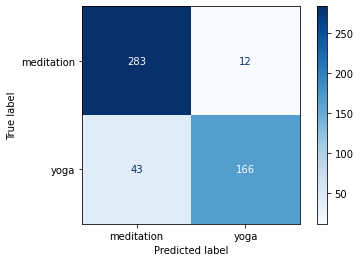

In [16]:
# plot confusion matrix
plot_confusion_matrix(lr_cvec_gs, X_test, y_test, display_labels=['meditation', 'yoga'], 
                      cmap='Blues', values_format='d');

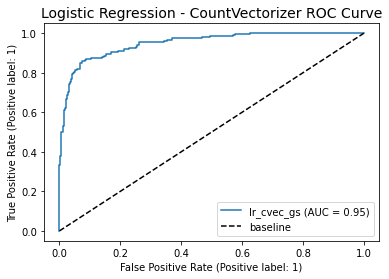

In [17]:
# plot roc curve
plot_roc_curve(lr_cvec_gs, X_test, y_test, name = 'lr_cvec_gs')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Logistic Regression - CountVectorizer ROC Curve', fontsize=14)
plt.legend();

In [18]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,vectorizer,cross_val_score,train accuracy,test accuracy,precision,recall,f1_score,roc_auc
0,Logistic Regression GridSearchCV,cvec,0.875745,0.973617,0.890873,0.932584,0.794258,0.857881,0.949899


According to the Confusion Matrix, it shows that the Logistic Regression model with Countvectorizer was able to correctly predict total 449 posts out of 504 posts. 12 False Positive (type I error) and 43 False Negative (type II error) that bring the Test Accuracy to 89.1%. As compared to Train accuracy, it shows the model was overfitted. With 43 type II errors, it bring the recall score to 79.4% and 12 type I errors allow the precision score at 93.3%. F1-score of 85.8% and ROC AUC score 95% both show the model is considered relatively good in classifying the posts.

#### *TfidfVectorizer - Logistic Regression*

In [19]:
%%time

# Instantiate GridSearchCV for TfidfVectorizer and LogisticRegression
# Specify recall as the metric to optimize
lr_tvec_gs = GridSearchCV(lr_tvec_pipe, lr_tvec_params, cv=5, verbose=1, n_jobs= -1)

# Fit the model
lr_tvec_gs.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Wall time: 23.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('t_lr',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'t_lr__C': [0.001, 0.01, 0.1, 1, 10],
                         't_lr__penalty': ['l1', 'l2'],
                         't_lr__solver': ['liblinear'],
                         'tvec__max_df': [0.2, 0.3, 0.4, 0.8, 0.9],
                         'tvec__max_features': [None],
                         'tvec__min_df': [2, 3, 4, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': ['english']},
             verbose=1)

In [20]:
# check best params and CV score
print(lr_tvec_gs.best_params_)
print(lr_tvec_gs.best_score_)

{'t_lr__C': 10, 't_lr__penalty': 'l2', 't_lr__solver': 'liblinear', 'tvec__max_df': 0.2, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
0.8842553191489362


In [21]:
# print the summarize report and store the values
run_score(lr_tvec_gs, 'tvec', 'Logistic Regression GridSearchCV')

====== Logistic Regression GridSearchCV's Metrics ======
Train Score: 0.9991489361702127
Test Score: 0.9007936507936508
Precision Score: 0.9441340782122905
Recall Score: 0.8086124401913876
f1-Score: 0.8711340206185567
roc_auc Score: 0.95239639931879

== confusion matrix ==
True Negatives: 285
False Positives: 10
False Negatives: 40
True Positives: 169


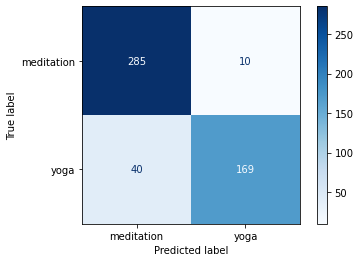

In [22]:
# plot confusion matrix
plot_confusion_matrix(lr_tvec_gs, X_test, y_test, display_labels=['meditation', 'yoga'],
                      cmap='Blues', values_format='d');

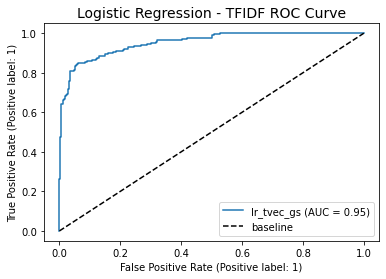

In [23]:
# plot roc curve
plot_roc_curve(lr_tvec_gs, X_test, y_test, name = 'lr_tvec_gs')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Logistic Regression - TFIDF ROC Curve', fontsize=14)
plt.legend();

In [24]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,vectorizer,cross_val_score,train accuracy,test accuracy,precision,recall,f1_score,roc_auc
0,Logistic Regression GridSearchCV,cvec,0.875745,0.973617,0.890873,0.932584,0.794258,0.857881,0.949899
1,Logistic Regression GridSearchCV,tvec,0.884255,0.999149,0.900794,0.944134,0.808612,0.871134,0.952396


According to the Confusion Matrix, it shows that the Logistic Regression model with TfidfVectorizer was able to correctly predict total 454 posts out of 504 posts. 10 False Positive (type I error) and 40 False Negative (type II error) that bring the Test Accuracy to 90%. As compared to Train accuracy, it still shows the model was overfitted. With 40 type II errors, it bring the recall score to 80.9% and 10 type I errors allow the precision score at 94.4%. F1-score of 87.1% and ROC AUC score 95.2% both show the model is considered relatively good in classifying the posts.

As such by using TFIDF Vectorizer it shows some improvements in overall score and accuracy as compared to same model but using Count Vectorizer.

### 7.4 Multinomial Naive Bayes

The __multinomial Naive Bayes classifier__ is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work. The algorithm is based on Bayes theorem where our target response is reprenseted as a probability function based on our text features. It describes the probability of an event based on conditions that might be related to the event.

**Naive Bayes** makes the assumption that all features are independent of one another (this is why it is called *naïve*). However, text data is never independent! Certain words can change the context of a sentence when used with other words. The way language works, we have words that are more or less likely to follow other words.

Although the assumption is not realisitc with NLP data, we still use Naive Bayes frequently as it is a very fast modeling algorithm and it is also a good classifier, somehow it will outperform more complicated models.

In [25]:
# Build pipeline for Countvectorizer and Naive Bayes
nb_cvec_pipe = Pipeline([('cvec', CountVectorizer()),
                         ('c_nb', MultinomialNB())])

# Set parameters for Countvectorizer and Naive Bayes
nb_cvec_params = {'cvec__max_features': [None],
                  'cvec__stop_words':['english'],
                  'cvec__min_df':[2, 3, 4, 5],
                  'cvec__max_df': [0.2, 0.3, 0.4, 0.8, 0.9],
                  'cvec__ngram_range':[(1,1), (1,2)],
                  'c_nb__alpha': [0.1, 0.5, 1 , 3, 5, 10],
                  'c_nb__fit_prior':[True, False]}

In [26]:
# Build pipeline for TfidfVectorizer and Naive Bayes
nb_tvec_pipe = Pipeline([('tvec',TfidfVectorizer()),
                         ('t_nb',MultinomialNB())])

# Set parameters for TfidfVectorizer and Naive Bayes
nb_tvec_params = {'tvec__max_features': [None],
                  'tvec__stop_words':['english'],
                  'tvec__min_df':[2, 3, 4, 5],
                  'tvec__max_df': [0.2, 0.3, 0.4, 0.8, 0.9],
                  'tvec__ngram_range':[(1,1), (1,2)],
                  't_nb__alpha': [0.1, 0.5, 1 , 3, 5, 10],
                  't_nb__fit_prior':[True, False]}

#### *CountVectorizer - Multinomial Naive Bayes*

In [27]:
%%time

# Instantiate GridSearchCV for Countvectorizer and Naive Bayes
# Specify recall as the metric to optimize
nb_cvec_gs = GridSearchCV(nb_cvec_pipe, nb_cvec_params, cv=5, verbose=1, n_jobs= -1)

# Fit the model
nb_cvec_gs.fit(X_train, y_train)
print(nb_cvec_gs.best_params_)
print(nb_cvec_gs.best_score_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
{'c_nb__alpha': 3, 'c_nb__fit_prior': False, 'cvec__max_df': 0.3, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
0.8902127659574468
Wall time: 27.7 s


In [28]:
# print the summarize report and store the values
run_score(nb_cvec_gs, 'cvec', 'Naive Bayes GridSearchCV')

====== Naive Bayes GridSearchCV's Metrics ======
Train Score: 0.9412765957446808
Test Score: 0.9067460317460317
Precision Score: 0.9175257731958762
Recall Score: 0.8516746411483254
f1-Score: 0.8833746898263026
roc_auc Score: 0.9465898953856136

== confusion matrix ==
True Negatives: 279
False Positives: 16
False Negatives: 31
True Positives: 178


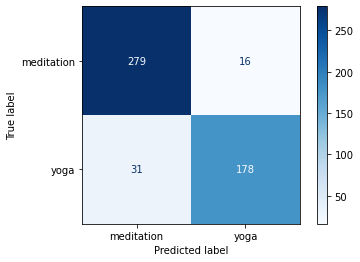

In [29]:
# plot confusion matrix
plot_confusion_matrix(nb_cvec_gs, X_test, y_test, display_labels=['meditation', 'yoga'],
                      cmap='Blues', values_format='d');

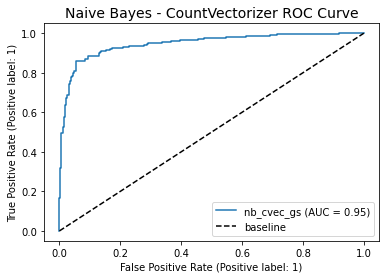

In [30]:
# plot roc curve
plot_roc_curve(nb_cvec_gs, X_test, y_test, name = 'nb_cvec_gs')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Naive Bayes - CountVectorizer ROC Curve', fontsize=14)
plt.legend();

In [31]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,vectorizer,cross_val_score,train accuracy,test accuracy,precision,recall,f1_score,roc_auc
0,Logistic Regression GridSearchCV,cvec,0.875745,0.973617,0.890873,0.932584,0.794258,0.857881,0.949899
1,Logistic Regression GridSearchCV,tvec,0.884255,0.999149,0.900794,0.944134,0.808612,0.871134,0.952396
2,Naive Bayes GridSearchCV,cvec,0.890213,0.941277,0.906746,0.917526,0.851675,0.883375,0.946590


According to the Confusion Matrix, it shows that the Multinomial Naive Bayes model with CountVectorizer was able to correctly predict total 457 posts out of 504 posts. 16 False Positive (type I error) and 31 False Negative (type II error) that bring the Test Accuracy to 90.7%. As compared to Train accuracy, it still shows the model slightly overfitted but it was much better as compared Logistic Regression model. With 31 type II errors, it bring the recall score to 85.2% and 16 type I errors allow the precision score at 91.8%. F1-score of 88.3% and ROC AUC score 94.7% both show the model is considered relatively good in classifying the posts.

As such by using Count Vectorizer on Multinomial Naive Bayes, it shows huge reduce in overfitting and improvements in overall score and accuracy as compared to Logistic Regression Model. Although the precision score drops, we are able to accept the increase numbers in False Positive (Type I error), which we predicted as yoga enthusiasts, but in fact it is non-yoga enthusiasts. There is still potential that we can convert this group of segment into dollar.

The most crucial metric is recall which we are able to maximize the True Positive and minimize the False Negative, so our Marketing team able maximize the marketing resource on the target segment (yoga enthusiasts) as much as possible.

#### *TfidfVectorizer - Multinomial Naive Bayes*

In [32]:
%%time

# Instantiate GridSearchCV for TfidfVectorizer and Naive Bayes
# Specify recall as the metric to optimize
nb_tvec_gs = GridSearchCV(nb_tvec_pipe, nb_tvec_params, cv=5, verbose=1, n_jobs= -1)

# Fit the model
nb_tvec_gs.fit(X_train, y_train)
print(nb_tvec_gs.best_params_)
print(nb_tvec_gs.best_score_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
{'t_nb__alpha': 0.5, 't_nb__fit_prior': False, 'tvec__max_df': 0.2, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}
0.8868085106382978
Wall time: 28.7 s


In [33]:
# print the summarize report and store the values
run_score(nb_tvec_gs, 'tvec', 'Naive Bayes GridSearchCV')

====== Naive Bayes GridSearchCV's Metrics ======
Train Score: 0.9693617021276596
Test Score: 0.8948412698412699
Precision Score: 0.9239130434782609
Recall Score: 0.8133971291866029
f1-Score: 0.8651399491094148
roc_auc Score: 0.9501905765955722

== confusion matrix ==
True Negatives: 281
False Positives: 14
False Negatives: 39
True Positives: 170


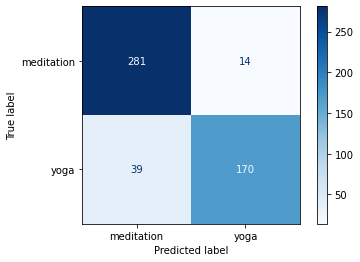

In [34]:
# plot confusion matrix
plot_confusion_matrix(nb_tvec_gs, X_test, y_test, display_labels=['meditation', 'yoga'],
                      cmap='Blues', values_format='d');

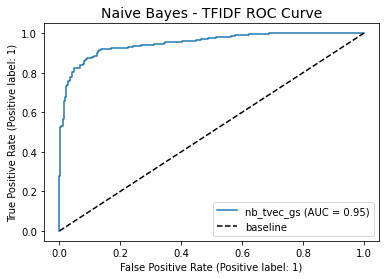

In [35]:
# plot roc curve
plot_roc_curve(nb_tvec_gs, X_test, y_test, name = 'nb_tvec_gs')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Naive Bayes - TFIDF ROC Curve', fontsize=14)
plt.legend();

In [36]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,vectorizer,cross_val_score,train accuracy,test accuracy,precision,recall,f1_score,roc_auc
0,Logistic Regression GridSearchCV,cvec,0.875745,0.973617,0.890873,0.932584,0.794258,0.857881,0.949899
1,Logistic Regression GridSearchCV,tvec,0.884255,0.999149,0.900794,0.944134,0.808612,0.871134,0.952396
2,Naive Bayes GridSearchCV,cvec,0.890213,0.941277,0.906746,0.917526,0.851675,0.883375,0.946590
3,Naive Bayes GridSearchCV,tvec,0.886809,0.969362,0.894841,0.923913,0.813397,0.865140,0.950191


According to the Confusion Matrix, it shows that the Multinomial Naive Bayes model with TFIDFVectorizer was able to correctly predict total 451 posts out of 504 posts. 14 False Positive (type I error) and 39 False Negative (type II error) that bring the Test Accuracy to 89.5%. As compared to Train accuracy, it still shows the model was overfitted but it was much better as compared Logistic Regression model. With 39 type II errors, it bring the recall score to 81.3% and 14 type I errors allow the precision score at 92.4%. F1-score of 86.5% and ROC AUC score 95% both show the model is considered relatively good in classifying the posts.

As such by using TFIDF Vectorizer on Multinomial Naive Bayes, it shows huge reduce in overfitting and improvements in overall score and accuracy as compared to Logistic Regression Model. Among Count Vectorizer and TFIDF Vectorizer on Naive Bayes, it shows that TFIDF Vectorizer have better precision score, while Count Vectorizer have better recall score. However Count Vectorizer still outperform TFIDF in term of F1-score.

### 7.5 Random Forest Classifier

The 3rd model we explored for classification modeling is __Random Forest Classifier__. The model works differently from logistic regression and naive bayes. It is a tree-based machine learning algorithm and as the name suggest, it consists of large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes out model's prediction. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

Random Forest works well as in not only the large number of decision trees, but also the "unrrelated models" or "low correlation" between the models is the key. Advantages of using Random Forest are roboust to outliers, works well with non-linear data and lower risk of overfitting. However it also have disadvantages that it found to be biased while dealing with categorial variables and take longer time in training.

In [37]:
# Build pipeline for Countvectorizer and RandomForest
rf_cvec_pipe = Pipeline([('cvec', CountVectorizer()),
                         ('c_rf', RandomForestClassifier(random_state = 42))])

# Set parameters for Countvectorizer and RandomForest
rf_cvec_params = {'cvec__max_features': [None],
                  'cvec__stop_words':['english'],
                  'cvec__min_df':[2, 3, 4, 5],
                  'cvec__max_df': [0.2, 0.3, 0.4, 0.8],
                  'cvec__ngram_range':[(1,1), (1,2)],
                  'c_rf__bootstrap': [True, False],
                  'c_rf__max_depth': [None, 10, 50, 100],
                  'c_rf__min_samples_split':[2, 3, 4, 5, 10], 
                  'c_rf__min_samples_leaf':[1, 2, 3]}

In [38]:
# Build pipeline for TfidfVectorizer and RandomForest
rf_tvec_pipe = Pipeline([('tvec',TfidfVectorizer()),
                         ('t_rf',RandomForestClassifier(random_state = 42))])

# Set parameters for TfidfVectorizer and RandomForest
rf_tvec_params = {'tvec__max_features': [None],
                  'tvec__stop_words':['english'],
                  'tvec__min_df':[2, 3, 4, 5],
                  'tvec__max_df': [0.2, 0.3, 0.4, 0.8],
                  'tvec__ngram_range':[(1,1), (1,2)],
                  't_rf__bootstrap': [True, False],
                  't_rf__max_depth': [None, 10, 50, 100],
                  't_rf__min_samples_split':[2, 3, 4, 5, 10], 
                  't_rf__min_samples_leaf':[1, 2, 3]}

#### *CountVectorizer - Random Forest Classifier*

In [39]:
%%time

# Instantiate GridSearchCV for TFIDF and RandomForest
# Specify recall as the metric to optimize
rf_cvec_gs = GridSearchCV(rf_cvec_pipe, rf_cvec_params, cv=5, verbose=1, n_jobs= -1)

# Fit the model
rf_cvec_gs.fit(X_train, y_train)
print(rf_cvec_gs.best_params_)
print(rf_cvec_gs.best_score_)

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits
{'c_rf__bootstrap': False, 'c_rf__max_depth': None, 'c_rf__min_samples_leaf': 2, 'c_rf__min_samples_split': 10, 'cvec__max_df': 0.3, 'cvec__max_features': None, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
0.8834042553191489
Wall time: 8min 43s


In [40]:
# print the summarize report and store the values
run_score(rf_cvec_gs, 'cvec', 'Random Forest GridSearchCV')

====== Random Forest GridSearchCV's Metrics ======
Train Score: 0.9940425531914894
Test Score: 0.9007936507936508
Precision Score: 0.9344262295081968
Recall Score: 0.8181818181818182
f1-Score: 0.8724489795918368
roc_auc Score: 0.961884680885573

== confusion matrix ==
True Negatives: 283
False Positives: 12
False Negatives: 38
True Positives: 171


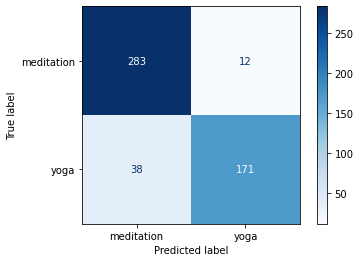

In [41]:
# plot confusion matrix
plot_confusion_matrix(rf_cvec_gs, X_test, y_test, display_labels=['meditation', 'yoga'],
                      cmap='Blues', values_format='d');

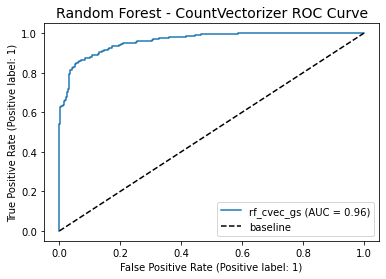

In [42]:
# plot roc curve
plot_roc_curve(rf_cvec_gs, X_test, y_test, name = 'rf_cvec_gs')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Random Forest - CountVectorizer ROC Curve', fontsize=14)
plt.legend();

In [43]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,vectorizer,cross_val_score,train accuracy,test accuracy,precision,recall,f1_score,roc_auc
0,Logistic Regression GridSearchCV,cvec,0.875745,0.973617,0.890873,0.932584,0.794258,0.857881,0.949899
1,Logistic Regression GridSearchCV,tvec,0.884255,0.999149,0.900794,0.944134,0.808612,0.871134,0.952396
2,Naive Bayes GridSearchCV,cvec,0.890213,0.941277,0.906746,0.917526,0.851675,0.883375,0.946590
3,Naive Bayes GridSearchCV,tvec,0.886809,0.969362,0.894841,0.923913,0.813397,0.865140,0.950191
4,Random Forest GridSearchCV,cvec,0.883404,0.994043,0.900794,0.934426,0.818182,0.872449,0.961885


According to the Confusion Matrix, it shows that the Random Forest Classifier model with CountVectorizer was able to correctly predict total 454 posts out of 504 posts. 12 False Positive (type I error) and 38 False Negative (type II error) that bring the Test Accuracy to 90.1%. As compared to Train accuracy, it still shows the model was overfitted. With 38 type II errors, it bring the recall score to 81.8% and 12 type I errors allow the precision score at 93.4%. F1-score of 87.2% and ROC AUC score 96.2% both show the model is considered relatively good in classifying the posts.

Overally, we do not see much improvements in score and accuracy from Naive Bayes to Random Forest Classifier. The model tend to overfit as compared to Naive Bayes.

#### *TfidfVectorizer - Random Forest Classifier*

In [44]:
%%time

# Instantiate GridSearchCV for TfidfVectorizer and RandomForest
# Specify recall as the metric to optimize
rf_tvec_gs = GridSearchCV(rf_tvec_pipe, rf_tvec_params, cv=5, verbose=1, n_jobs= -1)

# Fit the model
rf_tvec_gs.fit(X_train, y_train)
print(rf_tvec_gs.best_params_)
print(rf_tvec_gs.best_score_)

Fitting 5 folds for each of 3840 candidates, totalling 19200 fits
{'t_rf__bootstrap': True, 't_rf__max_depth': None, 't_rf__min_samples_leaf': 1, 't_rf__min_samples_split': 3, 'tvec__max_df': 0.3, 'tvec__max_features': None, 'tvec__min_df': 5, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}
0.8842553191489362
Wall time: 9min 25s


In [45]:
# print the summarize report and store the values
run_score(rf_tvec_gs, 'tvec', 'Random Forest GridSearchCV')

====== Random Forest GridSearchCV's Metrics ======
Train Score: 1.0
Test Score: 0.8690476190476191
Precision Score: 0.9132947976878613
Recall Score: 0.7559808612440191
f1-Score: 0.8272251308900523
roc_auc Score: 0.9578622982726462

== confusion matrix ==
True Negatives: 280
False Positives: 15
False Negatives: 51
True Positives: 158


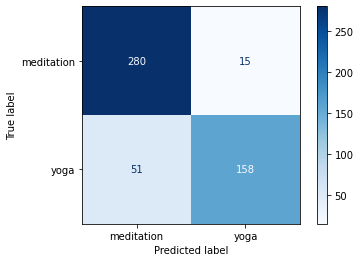

In [46]:
# plot confusion matrix
plot_confusion_matrix(rf_tvec_gs, X_test, y_test, display_labels=['meditation', 'yoga'],
                      cmap='Blues', values_format='d');

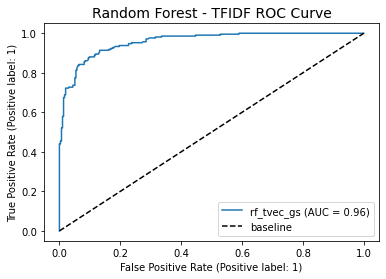

In [47]:
# plot roc curve
plot_roc_curve(rf_tvec_gs, X_test, y_test, name = 'rf_tvec_gs')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--' , color='black')

plt.title('Random Forest - TFIDF ROC Curve', fontsize=14)
plt.legend();

In [48]:
# Updated evaluation list
pd.DataFrame(evaluation_list)

,model,vectorizer,cross_val_score,train accuracy,test accuracy,precision,recall,f1_score,roc_auc
0,Logistic Regression GridSearchCV,cvec,0.875745,0.973617,0.890873,0.932584,0.794258,0.857881,0.949899
1,Logistic Regression GridSearchCV,tvec,0.884255,0.999149,0.900794,0.944134,0.808612,0.871134,0.952396
2,Naive Bayes GridSearchCV,cvec,0.890213,0.941277,0.906746,0.917526,0.851675,0.883375,0.946590
3,Naive Bayes GridSearchCV,tvec,0.886809,0.969362,0.894841,0.923913,0.813397,0.865140,0.950191
4,Random Forest GridSearchCV,cvec,0.883404,0.994043,0.900794,0.934426,0.818182,0.872449,0.961885
5,Random Forest GridSearchCV,tvec,0.884255,1.000000,0.869048,0.913295,0.755981,0.827225,0.957862


According to the Confusion Matrix, it shows that the Random Forest Classifier model with TFIDFVectorizer was able to correctly predict total 438 posts out of 504 posts. 15 False Positive (type I error) and 51 False Negative (type II error) that bring the Test Accuracy to 86.9%. As compared to Train accuracy, it still shows the model was overfitted. With 51 type II errors, it bring the recall score to 75.6% and 15 type I errors allow the precision score at 91.3%. F1-score of 82.7% and ROC AUC score 95.8% both show the model is considered relatively good in classifying the posts.

However, the 100% score in Train accuracy shows the model was overfitted and it will not be able to generalize to new datasets. Overally, we do not see much improvements in score and accuracy from Naive Bayes to Random Forest Classifier. In fact the model have the lowest score in test accuracy, precision, recall and f1-score.

### 7.6 Final Model

In [49]:
# convert the evaluation list into dataframe for data manipulation
evaluation_df = pd.DataFrame(evaluation_list)

# Sorted the evaluation dataframe by 'recall' and 'roc_auc' score
evaluation_df.sort_values(by = ['recall','roc_auc'], ascending=False)

,model,vectorizer,cross_val_score,train accuracy,test accuracy,precision,recall,f1_score,roc_auc
2,Naive Bayes GridSearchCV,cvec,0.890213,0.941277,0.906746,0.917526,0.851675,0.883375,0.946590
4,Random Forest GridSearchCV,cvec,0.883404,0.994043,0.900794,0.934426,0.818182,0.872449,0.961885
3,Naive Bayes GridSearchCV,tvec,0.886809,0.969362,0.894841,0.923913,0.813397,0.865140,0.950191
1,Logistic Regression GridSearchCV,tvec,0.884255,0.999149,0.900794,0.944134,0.808612,0.871134,0.952396
0,Logistic Regression GridSearchCV,cvec,0.875745,0.973617,0.890873,0.932584,0.794258,0.857881,0.949899
5,Random Forest GridSearchCV,tvec,0.884255,1.000000,0.869048,0.913295,0.755981,0.827225,0.957862


From the evaluation list of models we build, it shows that `Multinomial Naive Bayes` with `Count Vectorizer` top the list with highest __f1-score, recall score and test accuracy__. The model also shows less in overfitting as compared to the rest of models. Hence we decided to select Naive Bayes with Count Vectorizer as our final model to explore our top predictors and features.

In summary our Final Model:
- Multinomial Naive Bayes with alpha 3
- fit_prior to be False means a uniform prior will be used for class prior probabilities
- Use Count Vectorizer with no max feature limit
- include only single gram
- ignore terms that appear in more than 30% of the documents
- ignore terms that appear in less than 2 documents

### 7.7 Model Insights

In [50]:
# create index_list from nb_cvec_gs
index_list = nb_cvec_gs.best_estimator_.named_steps.cvec.get_feature_names()

# create yoga and meditation probabilities
yoga_prob = np.exp(nb_cvec_gs.best_estimator_.named_steps.c_nb.feature_log_prob_[1])
meditation_prob = np.exp(nb_cvec_gs.best_estimator_.named_steps.c_nb.feature_log_prob_[0]) 

# create dataframe for yoga and meditation probabilities
yoga_prob_df = pd.DataFrame(yoga_prob, index=index_list).rename(columns={0:'prob'}).reset_index()
meditation_prob_df = pd.DataFrame(meditation_prob, index=index_list).rename(columns={0:'prob'}).reset_index()

In [51]:
# print top 20 words with highest probabilities in r/yoga
yoga_prob_df = yoga_prob_df.sort_values('prob', ascending=False)
yoga_prob_df.head(20)

,index,prob
2469,practice,0.007282
2443,pose,0.006692
609,class,0.006415
3360,time,0.005444
1268,feel,0.005236
847,day,0.005062
1828,know,0.004993
3683,year,0.004958
3522,ve,0.003988
3570,want,0.003953


In [52]:
print(yoga_prob_df.head(20)['index'].values)

['practice' 'pose' 'class' 'time' 'feel' 'day' 'know' 'year' 've' 'want'
 'body' 'teacher' 'really' 'help' 'mat' 'week' 'pain' 'thing' 'way' 'good']


In [53]:
# print top 20 words with highest probabilities in r/Meditation
meditation_prob_df = meditation_prob_df.sort_values('prob', ascending=False)
meditation_prob_df.head(20)

,index,prob
1268,feel,0.009394
3340,thought,0.008079
3360,time,0.007709
2076,mind,0.006440
2039,meditating,0.006094
1890,life,0.005401
847,day,0.005401
1828,know,0.005101
3335,thing,0.004547
3570,want,0.004478


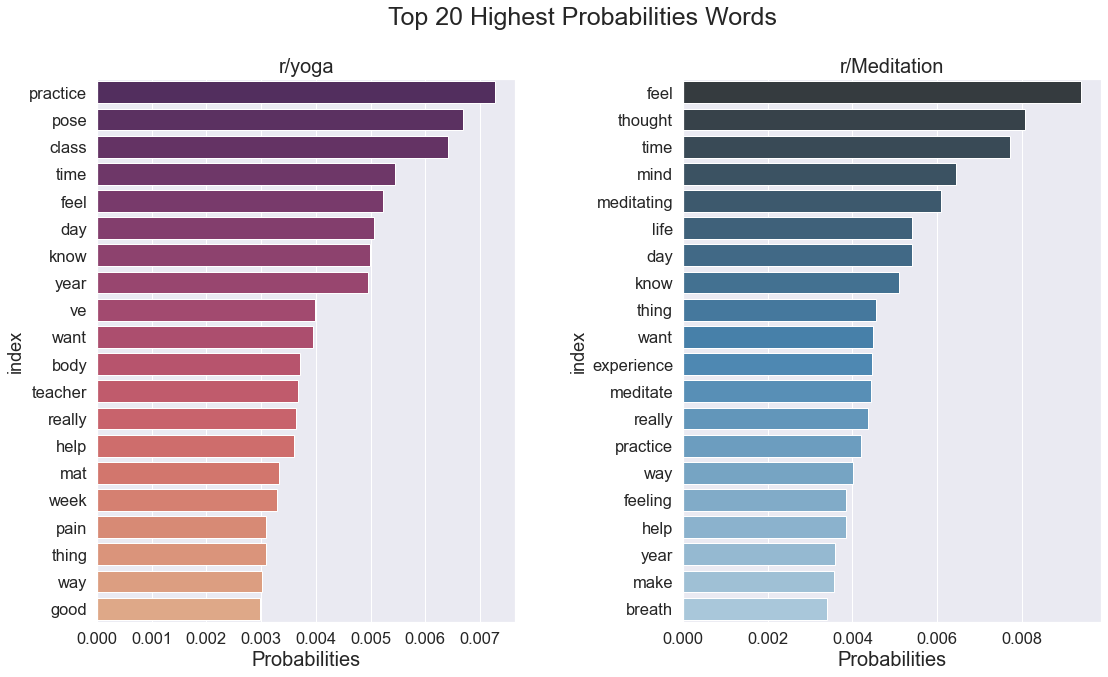

In [54]:
# plot the top 20 highest probabilities of words
subplot_top_proba(yoga_prob_df, meditation_prob_df, n=20, title='Top 20 Highest Probabilities Words')

- From the bar plots above, it shows the __Top 20 Highest Probabilities Predictors (words)__ that appearing in the class (Yoga Enthusiasts) out of all the words in the corpus. Top 3 of highest probabilities preditros are `class`, `pose` and `practice` which are all good predictors to indicate as Yoga Enthusiasts' posts. 
- Besides that, we also noticed that `mat`, `teacher`, `feel`, `body` and `pain` are in the list as well, it shows that there is a trending that the subrredit community members are posting on these keywords related posts which we able to use it for our marketing strategies development. 
- Lastly, it also revealed some of the less meaningful words like `day`, `ve`, `year`, `week`, `want`, `help`, `time`, `know`, `really`, `good`, `thing` and `way` that have high probabilities of appearing in the class out of all the words in the corpus.

 
__Note:__ Do note that although these are the highes probabilities of predictors, but it does not mean it will be 100% predict it as Yoga Enthusiasts merely on the word itself. Eventually the model will still evaluate the whole document or subreddit to classify accordingly.

In [55]:
# identify the top 3 predictors from r/yoga
yoga_prob_df['index'].head(3)   

2469    practice
2443        pose
609        class
Name: index, dtype: object

In [56]:
# show first 5 rows of the datasets with yoga enthusiasts and with top predictor of 'practice'
print(yoga_medit[(yoga_medit['lem_combine_text'].str.contains('practice'))&(yoga_medit['is_yoga']==1)].shape)
yoga_medit[(yoga_medit['lem_combine_text'].str.contains('practice'))&(yoga_medit['is_yoga']==1)].head()

(181, 22)


,is_yoga,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,author,permalink,...,clean_title,clean_selftext,combine_text,lem_title,lem_selftext,lem_combine_text,title_length,title_wcount,selftext_length,selftext_wcount
2,1,Yoga with COVID,Hi all. \n\nI was diagnosed with COVID last we...,True,0,1640895222,2021-12-31 04:13:42,NaN,dreamingofcupcakes,/r/yoga/comments/rsazdv/yoga_with_covid/,...,yoga with covid,hi all i was diagnosed with covid last week an...,yoga with covid hi all i was diagnosed with co...,covid,hi diagnosed covid week really giving real bad...,covid hi diagnosed covid week really giving re...,15,3,526,92
3,1,My heart is so full.,I just came from a 75 minute class and I was s...,True,0,1640885021,2021-12-31 01:23:41,NaN,nachosmmm,/r/yoga/comments/rs6zpd/my_heart_is_so_full/,...,my heart is so full,i just came from a 75 minute class and i was s...,my heart is so full i just came from a 75 minu...,heart,came 75 minute class sobbing end teacher amazi...,heart came 75 minute class sobbing end teacher...,19,5,1017,206
7,1,Men's Yoga Suggestions?,Hello everyone!\n\nI have convinced my husband...,True,0,1640851343,2021-12-30 16:02:23,NaN,littlemsmuffet,/r/yoga/comments/rrwb7e/mens_yoga_suggestions/,...,mens yoga suggestions,hello everyone i have convinced my husband to ...,mens yoga suggestions hello everyone i have co...,men suggestion,hello convinced husband adrienne beginning yea...,men suggestion hello convinced husband adrienn...,21,3,532,106
9,1,Pelvic tilt and yoga practice.,Just want to share with You something that mig...,True,0,1640838938,2021-12-30 12:35:38,NaN,Zuallemfahig,/r/yoga/comments/rrslkg/pelvic_tilt_and_yoga_p...,...,pelvic tilt and yoga practice,just want to share with you something that mig...,pelvic tilt and yoga practice just want to sha...,pelvic tilt practice,want share obvious amazing thing discovered pe...,pelvic tilt practice want share obvious amazin...,29,5,779,146
11,1,"Hips are always tight, even with consistent pr...",Hey everyone. I have an issue - it seems that ...,True,0,1640833072,2021-12-30 10:57:52,NaN,pinsandn33dles,/r/yoga/comments/rrqlvx/hips_are_always_tight_...,...,hips are always tight even with consistent pra...,hey everyone i have an issue it seems that no...,hips are always tight even with consistent pra...,hip tight consistent practice,hey issue matter practice routine hip tight ty...,hip tight consistent practice hey issue matter...,51,8,1372,266


In [57]:
# show first 2 rows of the datasets with yoga enthusiasts and with top predictor of 'pose'
print(yoga_medit[(yoga_medit['lem_combine_text'].str.contains('pose'))&(yoga_medit['is_yoga']==1)].shape)
yoga_medit[(yoga_medit['lem_combine_text'].str.contains('pose'))&(yoga_medit['is_yoga']==1)].head(2)

(177, 22)


,is_yoga,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,author,permalink,...,clean_title,clean_selftext,combine_text,lem_title,lem_selftext,lem_combine_text,title_length,title_wcount,selftext_length,selftext_wcount
0,1,Extremely sore after my first hot vinyasa class,I am super out of shape so I am 90% sure that ...,True,0,1640903618,2021-12-31 06:33:38,NaN,meggriffinsglasses,/r/yoga/comments/rse7eh/extremely_sore_after_m...,...,extremely sore after my first hot vinyasa class,i am super out of shape so i am 90 sure that i...,extremely sore after my first hot vinyasa clas...,extremely sore hot vinyasa class,super shape 90 sure issue wanted know normal p...,extremely sore hot vinyasa class super shape 9...,47,8,1041,222
11,1,"Hips are always tight, even with consistent pr...",Hey everyone. I have an issue - it seems that ...,True,0,1640833072,2021-12-30 10:57:52,NaN,pinsandn33dles,/r/yoga/comments/rrqlvx/hips_are_always_tight_...,...,hips are always tight even with consistent pra...,hey everyone i have an issue it seems that no...,hips are always tight even with consistent pra...,hip tight consistent practice,hey issue matter practice routine hip tight ty...,hip tight consistent practice hey issue matter...,51,8,1372,266


In [58]:
# show first 3 rows of the datasets with yoga enthusiasts and with top predictor of 'class'
print(yoga_medit[(yoga_medit['lem_combine_text'].str.contains('class'))&(yoga_medit['is_yoga']==1)].shape)
yoga_medit[(yoga_medit['lem_combine_text'].str.contains('class'))&(yoga_medit['is_yoga']==1)].head(3)

(153, 22)


,is_yoga,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,author,permalink,...,clean_title,clean_selftext,combine_text,lem_title,lem_selftext,lem_combine_text,title_length,title_wcount,selftext_length,selftext_wcount
0,1,Extremely sore after my first hot vinyasa class,I am super out of shape so I am 90% sure that ...,True,0,1640903618,2021-12-31 06:33:38,NaN,meggriffinsglasses,/r/yoga/comments/rse7eh/extremely_sore_after_m...,...,extremely sore after my first hot vinyasa class,i am super out of shape so i am 90 sure that i...,extremely sore after my first hot vinyasa clas...,extremely sore hot vinyasa class,super shape 90 sure issue wanted know normal p...,extremely sore hot vinyasa class super shape 9...,47,8,1041,222
3,1,My heart is so full.,I just came from a 75 minute class and I was s...,True,0,1640885021,2021-12-31 01:23:41,NaN,nachosmmm,/r/yoga/comments/rs6zpd/my_heart_is_so_full/,...,my heart is so full,i just came from a 75 minute class and i was s...,my heart is so full i just came from a 75 minu...,heart,came 75 minute class sobbing end teacher amazi...,heart came 75 minute class sobbing end teacher...,19,5,1017,206
5,1,Sacred cacao ceremony,I am usually a straight up hot yoga girl.\n\nT...,True,0,1640868870,2021-12-30 20:54:30,NaN,morncuppacoffee,/r/yoga/comments/rs15aq/sacred_cacao_ceremony/,...,sacred cacao ceremony,i am usually a straight up hot yoga girl the s...,sacred cacao ceremony i am usually a straight ...,sacred cacao ceremony,usually straight hot girl studio i’ve joined t...,sacred cacao ceremony usually straight hot gir...,21,3,503,99


In [59]:
# show first 3 rows of the datasets with yoga enthusiasts and with top predictor of 'class'
print(yoga_medit[(yoga_medit['lem_combine_text'].str.contains('class')) & 
           (yoga_medit['lem_combine_text'].str.contains('practice')) &
           (yoga_medit['lem_combine_text'].str.contains('pose')) &
           (yoga_medit['is_yoga']==1)].shape)

yoga_medit[(yoga_medit['lem_combine_text'].str.contains('class')) & 
           (yoga_medit['lem_combine_text'].str.contains('practice')) &
           (yoga_medit['lem_combine_text'].str.contains('pose')) &
           (yoga_medit['is_yoga']==1)].head(3)

(12, 22)


,is_yoga,title,selftext,is_self,num_comments,created_utc,created,removed_by_category,author,permalink,...,clean_title,clean_selftext,combine_text,lem_title,lem_selftext,lem_combine_text,title_length,title_wcount,selftext_length,selftext_wcount
24,1,Downward Dog is NOT a Beginner Pose,I would really love to get into Yoga and pract...,True,0,1640746883,2021-12-29 11:01:23,NaN,Studly_Wonderballs,/r/yoga/comments/rqxehh/downward_dog_is_not_a_...,...,downward dog is not a beginner pose,i would really love to get into yoga and pract...,downward dog is not a beginner pose i would re...,downward dog beginner pose,really love practice regularly beginner video ...,downward dog beginner pose really love practic...,35,7,1167,232
130,1,Do you guys learn the original names of the as...,"as an Indian, its interesting how westernized ...",True,0,1640089270,2021-12-21 20:21:10,NaN,Drenuous,/r/yoga/comments/rldjbf/do_you_guys_learn_the_...,...,do you guys learn the original names of the as...,as an indian its interesting how westernized y...,do you guys learn the original names of the as...,guy learn original name asanasyoga posture pra...,indian interesting westernized year noticed as...,guy learn original name asanasyoga posture pra...,76,13,1005,174
236,1,I think I accidentally got a yoga teacher fired.,"(I'm a guy, if that's relevant to the story. I...",True,0,1639418348,2021-12-14 01:59:08,NaN,BigBobbert,/r/yoga/comments/rflr2o/i_think_i_accidentally...,...,i think i accidentally got a yoga teacher fired,im a guy if thats relevant to the story it mig...,i think i accidentally got a yoga teacher fire...,think accidentally got teacher fired,guy thats relevant story know started going ne...,think accidentally got teacher fired guy thats...,47,9,1808,343


In [60]:
# explore the combine_text that contains with 'practice'
yoga_medit[(yoga_medit['lem_combine_text'].str.contains('practice'))&(yoga_medit['is_yoga']==1)]['combine_text'].values[1]

'my heart is so full i just came from a 75 minute class and i was sobbing at the end this teacher is so amazing the imagery at the end was just so beautiful she asked us to walk into a warmly lit cave or space in our hearts and as you walk deeper the light gets brighter and brighter you come to a door and you have the key and you unlock it the door opens and you are enveloped in lightlove i just had these feeling that this light was love and life and also death i did my yoga teacher training this year and there have been a few other times when i have cried in savasana and i can literally feel love in my heart another time i felt the love expanding all around me and that time i sobbed for quite some time i feel that this is literally a healing that trauma or some kind of energy is leaving the body and is being replaced with love maybe i need to share this on the spiritual subreddit as well but i just wanted to share yoga is so so amazing and beautiful i hope everyone can find what they 

In [61]:
# explore the combine_text that contains with 'pose'
yoga_medit[(yoga_medit['lem_combine_text'].str.contains('pose'))&(yoga_medit['is_yoga']==1)]['combine_text'].values[1]

'hips are always tight even with consistent practice hey everyone i have an issue  it seems that no matter how often i practice yoga and keep on top of my routine my hips are always tight i typically do a 45 minute hips focused routine twice a week that covers hamstrings lower back quads and hips it is very in depth and features multiple poses for each muscle group when i am done the routine my hips feel great and are very mobile then i exercise or go a few days between practice and it’s like i never did the yoga and am back to square one not even being able to sit cross legged without serious tightness in my hips i train jiu jitsu and hip mobility it critical to the art so it is important for me that i maintain good mobility however it is frustrating that it seems i make zero progress and am just as tight a year after starting my yoga practice is there something i am doing wrong i have tried various routines i take hot baths after exercise to keep my muscles from tightening up i stret

In [62]:
# explore the combine_text that contains with 'class'
yoga_medit[(yoga_medit['lem_combine_text'].str.contains('class'))&(yoga_medit['is_yoga']==1)]['combine_text'].values[0]

'extremely sore after my first hot vinyasa class i am super out of shape so i am 90 sure that is the issue but i wanted to know if this is normal for a person who has never done yoga in their life i used the search bar but most of people who asked about muscle soreness stated that they had done yoga before and vinyasa made them feel sore for the first time i am a complete newbie to yoga i had a wonderful time and plan to go back in a few days but i just wanted to know if this is something i should be concerned about while i was doing the poses i felt fine of course i wasn’t able to do every pose perfectly but nothing hurt and it was a very satisfying challenge what caught me off guard was the way i felt when i woke up this morning i felt like i got hit by a car or something i am assuming this is just because it’s my first time exercising in a really long time i didn’t even feel sore like this when i used to lift weights should i be worried i took a nap and when i woke up i did feel a b

In [63]:
# explore the combine_text that contains with top 3 predictors
yoga_medit[(yoga_medit['lem_combine_text'].str.contains('class')) & 
           (yoga_medit['lem_combine_text'].str.contains('practice')) &
           (yoga_medit['lem_combine_text'].str.contains('pose')) &
           (yoga_medit['is_yoga']==1)]['combine_text'].values[0]

'downward dog is not a beginner pose i would really love to get into yoga and practice it regularly but every beginner video is always the same it starts with a few simple poses that i find difficult but power through and then about ten minutes in they break into downward dog and every pose from then on is a variation of downward dog for the life of me i do not know how they expect a beginner to be able to jump into that pose on their first day i do not have the flexibility in my back to make that pose i do not have the strength or flexibility in my shoulders to do that pose and i absolutely do not have the flexibility in my calves and hamstrings to do that pose i cant do it at all im just planking with my butt slightly in the air and i can only hold it for 20 seconds i dont think ive ever seen a beginner even come close to doing anything like it so two things 1 if youre an instructor take downward dog out of your beginner classes dont make it the foundational pose for every other pose

In [74]:
# explore the combine_text that contains with top 3 predictors
yoga_medit[(yoga_medit['lem_combine_text'].str.contains('class')) & 
           (yoga_medit['lem_combine_text'].str.contains('practice')) &
           (yoga_medit['lem_combine_text'].str.contains('pose')) &
           (yoga_medit['is_yoga']==1)]['combine_text'].values[6]

'struggling with yin yoga a bit of background info i have been running and lifting weights for about a decade and began practicing yoga 4 years ago this began with classes at my local gym and since covid hit i’ve “attended” a lot of youtube video classes i try to practice a few times a week i’ve always been a big fan of hot and vinyasa classes sweaty challenging fast paced classes with lots of planks chaturangas and abdominal work i try to throw in the occasional yin practice in an effort to rest but find it very difficult mentally it is very uncomfortable for me to be still in a pose for even a few minutes and hard to stop my mind from racing has anyone else had this experience with gentler styles of yoga does it get easier'

From the 4 posts above which consists of r/yoga top 3 predictors `class`, `practice` and `pose`, it revealed that it consists of sharing of feeling after yoga class / self practice at home. However most of the users have concern or challenges faced when practicing the yoga by themself especially for beginner. They may have the issue with the correct yoga posture and most of them may lead to body soreness, hip tight or the other parts of the body. Some of them may find it too difficult for beginner to practice some yoga pose eg. downward dog. 

*__Top Unique Predictors and Top Commonality__*  

From the top 20 predictors of both subreddits, it revealed that some differences and similarities among r/yoga and r /Meditation. At this section, we will identify the top unique predictors of r/yoga and top commonality between r/yoga and r/Meditation.

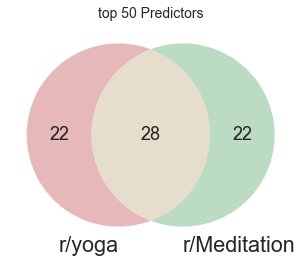

In [64]:
# plot a venn diagram to show numbers of similarity and difference words in top 50 predictors
venn2([set(yoga_prob_df.head(50)['index'].values), 
       set(meditation_prob_df.head(50)['index'].values)], set_labels = ('r/yoga','r/Meditation'))
plt.title('top 50 Predictors', fontsize=14)
plt.tight_layout()

In [65]:
# idenfity the unique words from r/yoga
yoga_unique_list = []
for unique in yoga_prob_df.head(50)['index'].values:
    if unique not in meditation_prob_df.head(50)['index'].values:
        yoga_unique_list.append(unique)

print(f"Numbers of Unique Words: {len(yoga_unique_list)}")        
print(yoga_unique_list)

Numbers of Unique Words: 22
['pose', 'class', 'teacher', 'mat', 'week', 'pain', 'studio', 'video', 'thanks', 'leg', 'stretch', 'flexibility', 'dog', 'looking', 'long', 'hip', 'beginner', 'hi', 'able', 'practicing', 'knee', 'instructor']


We decided to check further on top 50 predictors on both r/yoga and r/Meditation and find out the unique predictors of r/yoga that does not occur in r/Meditation.

From venn diagram above, we found that there was 22 unique predictors of r/yoga that does not occur in r/Meditation and 28 predictors in commonality. At one glace, it shows that mainly unique predictors are those yoga poses related eg. `pose`, `dog`, `hip`, `stretch`, `knee` and `leg`. While others like `teacher`, `instructor`, `studo`, `class`, `video`, `beginner` and `practicing` are those popular discussions topics in the subreddit community.

In [66]:
# idenfity the commonality words between r/yoga and r/Meditation
common_list = []
for common in yoga_prob_df.head(50)['index'].values:
    if common in meditation_prob_df.head(50)['index'].values:
        common_list.append(common)

print(f"Numbers of Common Words: {len(common_list)}")        
print(common_list)

Numbers of Common Words: 28
['practice', 'time', 'feel', 'day', 'know', 'year', 've', 'want', 'body', 'really', 'help', 'thing', 'way', 'good', 'started', 'start', 'new', 'work', 'lot', 'love', 'experience', 'people', 'need', 'make', 'right', 'think', 'month', 'going']


In [67]:
# identify the top unique predictors in r/yoga against r/Meditation
top_unique_yoga = yoga_prob_df[yoga_prob_df['index'].isin(yoga_unique_list)]

# identify the top commonality predictors between r/yoga and r/Meditation
top_common = yoga_prob_df[yoga_prob_df['index'].isin(common_list)]

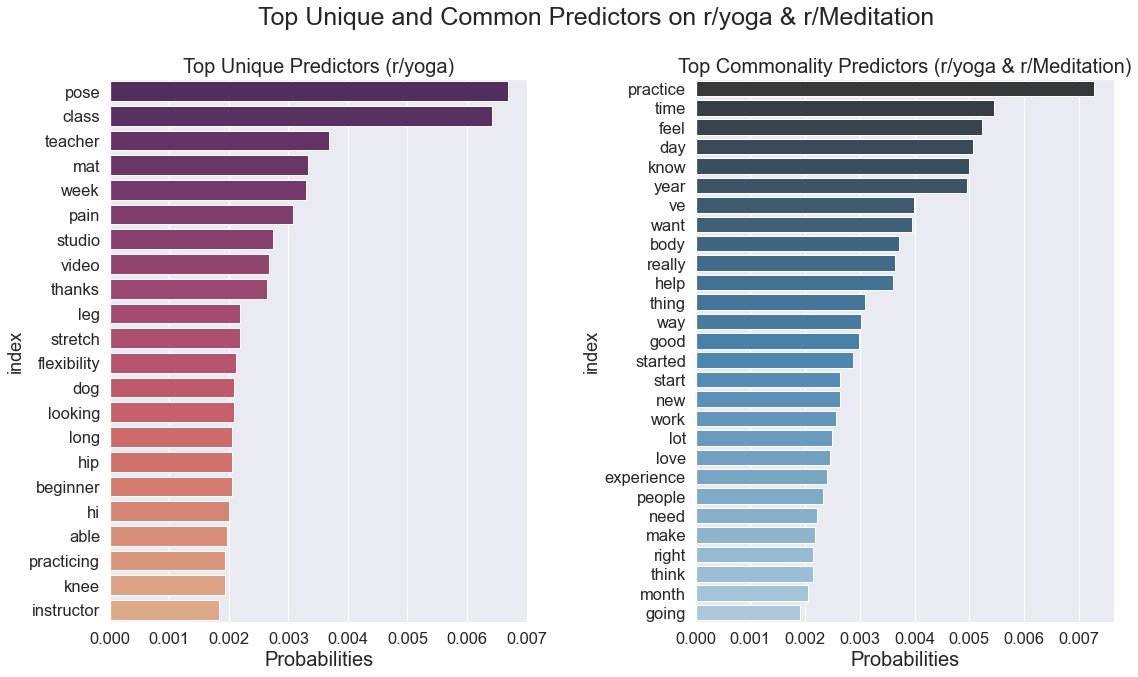

In [68]:
# plot the top unique and commonality predictors
plt.figure(figsize=(18,10))
sns.set(font_scale = 1.5)

palette1 = sns.color_palette("flare",n_colors=22)
palette1.reverse()
palette2 = sns.color_palette("Blues_d",n_colors=28)
palette2.reverse()

ax1 = plt.subplot(1,2,1)
ax1 = sns.barplot(y='index',x='prob', data=top_unique_yoga, palette=palette1)
ax1 = plt.xlabel('Probabilities',fontsize = 20)
ax1 = plt.title("Top Unique Predictors (r/yoga)", fontsize = 20)

ax2 = plt.subplot(1,2,2)
ax2 = sns.barplot(y='index',x='prob', data=top_common, palette=palette2)
ax2 = plt.xlabel("Probabilities", fontsize = 20)
ax2 = plt.title("Top Commonality Predictors (r/yoga & r/Meditation)", fontsize = 20)
    
plt.suptitle('Top Unique and Common Predictors on r/yoga & r/Meditation', fontsize=25)
plt.subplots_adjust(wspace=0.4)

From bar plots above, we able to clearly see that there was 2 predictors `pose` and `class` with high probabilities among the Top Unique Predictors for r/yoga. Which clearly distinct from r/Meditation and shows that yoga tend to be more claass-based and focusing on body posture where meditation tend to be more self practice and mind focus.

There are 2 trending words that we identify from the Top Unique Predictors are `yoga` and `flexibility`, both words are not in top 20 predictors, however their probabilities are in top 50 hence it shows that Yoga Enthusiasts are looking not only correct posture but also gaining `flexibility` is their concern in Yoga. Besides that, due to COVID pandemic, lot of government may have implement the safety distance measurements, work from home and avoid crowds are a norms in many countries, hence `video` become more and more in needs by Yoga Enthusiasts so that they able to self practice at home and at their convenience. 

From the Top Commonality Predictors between subreddits, it shows that the top 3 common predictors are `practice`, `time` and `feel`. It revealead that both yoga and meditation need lot of practicing and time spent, hence the posts mostly will be discussing on the practice issue, the time needed for the session and the feel eg. physical body feel for yoga and psychologically as well as mentally feel for meditation.


## 8.0 Conclusions and Recommendations

### 8.1 Findings

1) Classifying the subreddits as Yoga Enthusiasts, our best model is Multinomial Naive Bayes with Counter Vectorizer can provide 90.67% accuracy in classifying yoga or non-yoga enthusiasts. Recall score of 85.17% and F1-score of 88.34%.


2) There is a limitation on the final model we build (Multinomial Naive Bayes):
    
- The accuracy of the model restricted to the total numbers of 3000 posts scrapped from subreddit between from 2021-12-31 to 2021-11-07 on r/yoga and r/Meditation only. In order to test our model generalizability on new data, we need to have more data for model testing and evaluation.   
- we also added in `yoga` and `meditation` into stop words listing, it further reduce the overall accuracy score of the model.   
- The text classifier model currently build to classify on binary classes. It has not yet be able to classify multi classes.
    
    
3) From EDA, we find that yoga enthusiasts prefer to post the subreddit using non-text post for example like videos and images. While on the other hand, r/Meditation community prefer text posting and it have average longer posting in words and length as compared to r/yoga. r/yoga prefer to leave comments on the post rather than using the upvote system.


4) From our Sentiment Analysis, it revealed that both r/yoga and r/Meditation have positive sentiment in average where r/yoga have slightly higher in positive sentiment (0.401) in average as compared to r/Meditation (0.393). It also shows that the users in r/yoga community have positive sentiment towards `yoga` where we may infer that about 70% of the r/yoga community users have high willingness and acceptance on yoga and high chances to be 'Yoga Enthusiasts' that our Marketing Team can target on.  


5) We manage to identify top predictors from the text classifier model, Top 3 meaningful highest probabilities predictors are `class`, `pose` and `practice` which are all good predictors to indicate as Yoga Enthusiasts' posts. We also noticed that `mat`, `teacher`, `feel`, `body` and `pain` are in the list as well. From the Venn Diagram, we found that there was total 22 unique predictors of r/yoga, Those unique predictors with yoga poses related eg. `dog`, `hip`, `stretch`, `knee` and `leg`. Out of these unique predictors, we able to identified 2 trending words `video` and `flexibility`. Besides that, there was 28 predictors in common between subreddits where top 3 are `practice`, `time` and `feel`. Our marketing team can also explore the common interest on the new segment that potentially can be converted to our member. 

### 8.2 Recommendations

Based on our text classifier model and findings from this project, we manage to accomplish the two goals specified in our problem statement:
 
1) Our text classifier able to achieve 90.67% accuracy, 85.17% Recall score and 88.34% of F1-score in identifying Yoga Enthusiasts from the subreddit posts. This will allow our Marketing Team to maximize the marketing resources on the correct target segment (Yoga Enthusiasts). This approach will be more efficient, effective and cost-saving as compared to traditional approach that required lot of time and manpower resources to conduct research. With the high accuracy score, our marketing resources can be maximized to spent on the right segment.


2) Our Marketing Team can develop the Marketing Strategies and yoga packages that base on our top highest probabilities words as a predictor. When targeting on Yoga Enthusiasts, the team can target on below key words:

    1. practice
    2. pose
    3. class
    4. mat
    5. teacher
    6. feel
    7. body
    8. pain

From the predictors, we understand that the majority of it was about the yoga body posture and the effect or feeling after yoga that makes the concern and challenge by yoga enthusiasts. Our Marketing Team can develop the marketing strategies that emphasize on addressing these concerns. For example we will have additional co-instructor that able to provide guidance on body posture during the class when main instructor is doing the yoga. Besides that the team can provide a Complimentary Yoga Mat for new sign up with our yoga studio. 

3) Our Text Classifier Model can also identify the trending words that Marketing Team used it for improving or expanding existing product and services and develop marketing trend that factor in what is on trending. In this project we manage to identify `video` and `flexibility`. In view of COVID pandemic, Yoga Enthusiasts are looking for videos for self practicing at home and at their convenience, hence the Marketing Team can provide the package for new sign up to have the exclusive yoga videos access via website or phone app 24/7 anywhere as a member privilege. Another trending word `flexibility` are those Yoga Enthusiasts ultimately want to improve. The team also can modify the yoga class that not only targeting correct body posture, but also improving in flexibility which the key word will attract the eyeball of Yoga Enthusiasts.

*__Additional Recommendations:__*

4) Both r/yoga and r/Meditation consists of 28 commonality in predictors where the Marketing Team can also take these predictors to develop a marketing strategy that can explore new potential segment on r/Meditation users by identifying their common interest. Potentially the new segment can also be converted to join our Yoga Studio.

### 8.3 Future Enhancements

- Our project is to focus on datasets scrapped from Reddit submissions posts (before December 31, 2021 12:00:00 AM), we will try to scrap more posts for training as well as testing our models accuracy by using different period of posts.

- Besides __submissions__ posts, we will also want to scrap the data from __Hot__ and __Top__ sections of subreddit as both sections should have exist for some time and have more trending discussions and hot topics to explore.

- We will also wish to conduct sentiment analysis on the comments sections on each posts, this allow us to understand better on the yoga enthusiasts sentiments.

- We will also update those less meaningful words into our stop words listing for our text classifier in order to further identify more meaningful predictors.

- Other than the models (Logistic Regression, Multinomial Naive Bayes, Random Forest Classifier) we used in this project, we would also like to explore on the other classification models eg. Support Vector Machine (SVM), Gradient Boosting Classifier and Deep Learning Models to check if the outcome will be better off.


### 8.4 Citations

1. https://praw.readthedocs.io/en/stable/code_overview/models/submission.html
2. https://www.epochconverter.com/
3. https://www.web2generators.com/html-based-tools/online-html-entities-encoder-and-decoder
4. https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221
5. https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/
6. https://www.techopedia.com/definition/31605/upvote
7. https://theyogainstitute.org/difference-between-yoga-and-meditation/
8. https://towardsai.net/p/machine-learning/why-choose-random-forest-and-not-decision-trees
9. https://github.com/pushshift/api
10. https://www.ukessays.com/essays/marketing/traditional-way-of-segmenting-the-market-marketing-essay.php
11. https://timesofindia.indiatimes.com/life-style/health-fitness/fitness/alert-ways-yoga-can-harm-you/articleshow/46878232.cms#:~:text=Incorrect%20postures%20could%20lead%20to,metabolism%2C%20heart%20rate%20and%20respiration.